In [ ]:
!pip install easyfsl

In [19]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot

from torchvision.io import read_image
from tqdm import tqdm

import torchvision.models as models

from easyfsl.data_tools import TaskSampler, EasySet
from easyfsl.utils import plot_images, sliding_average

from random import random

In [15]:
!pwd

/home/ubuntu/workspace/easy-few-shot-learning/notebooks


In [2]:
# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = EasySet("../train_set_config.json")
print(len(train_set.labels))

2501


In [20]:
image_size = 28
test_set = EasySet("../test_set_config.json")
print(len(test_set.labels))

152


In [21]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

#convolutional_network = models.alexnet(pretrained=True)
#convolutional_network = vit_l_32(pretrained=True)
#convolutional_network = alexnet(pretrained=True)
convolutional_network = models.resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)


model = PrototypicalNetworks(convolutional_network).cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
N_WAY = 2 # Number of classes in a task
N_SHOT = 20 # Number of images per class in the support set
N_QUERY = 30 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
#test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(next(iter(test_loader)))

/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


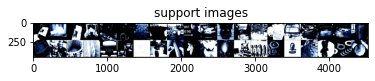

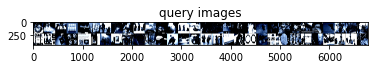

In [22]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [ ]:
print(example_support_images[0])

In [23]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{example_query_labels[i]} / {example_predicted_labels[i]}"
    )


Ground Truth / Predicted
0 / 0
0 / 1
0 / 0
0 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 1
0 / 0
0 / 0
0 / 0
0 / 1
0 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 0
1 / 1
1 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 0
1 / 0
1 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


In [38]:
_, class_pred = torch.max(example_scores.data,1)
print(class_pred[0].item())

0


In [8]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader, name):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
    
    accuracy = round((100 * correct_predictions/total_predictions), 2)
    
    print(
        f"{name} tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    
    return accuracy

#evaluate(test_loader)

In [11]:
names = []
outputs = []
for name in models.__dict__:
    names.append(name)
    outputs.append(100*round(random(),4))
    

print(names)
print(outputs)    

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'alexnet', 'AlexNet', 'convnext', 'ConvNeXt', 'convnext_tiny', 'convnext_small', 'convnext_base', 'convnext_large', 'resnet', 'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2', 'vgg', 'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'squeezenet', 'SqueezeNet', 'squeezenet1_0', 'squeezenet1_1', 'inception', 'Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs', 'densenet', 'DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'googlenet', 'GoogLeNet', 'GoogLeNetOutputs', '_GoogLeNetOutputs', '_utils', 'mobilenetv2', 'mobilenetv3', 'mobilenet', 'MobileNetV2', 'mobilenet_v2', 'MobileNetV3', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mnasnet', 'MNASNet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'm

In [9]:
import pandas as pd

names = []
outputs = []

for name in models.__dict__:
    try:
        arch = models.__dict__[name](pretrained=True)
        arch.fc = nn.Flatten()
        model = PrototypicalNetworks(arch).cuda()
        output = evaluate(test_loader, name)
        names.append(name)
        outputs.append(output)
    except:
        print("failed: Not a model")
        
results = {'Architecture':names, 'Accuracy':outputs}
df = pd.DataFrame(results)
print(df)

failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model


/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


alexnet tested on 100 tasks. Accuracy: 76.25%
failed: Not a model
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


convnext_tiny tested on 100 tasks. Accuracy: 82.83%


100%|███████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


convnext_small tested on 100 tasks. Accuracy: 81.32%


100%|███████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


convnext_base tested on 100 tasks. Accuracy: 83.30%


100%|███████████████████████████████████████████████████████████| 100/100 [06:06<00:00,  3.66s/it]


convnext_large tested on 100 tasks. Accuracy: 81.97%
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


resnet18 tested on 100 tasks. Accuracy: 83.12%


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


resnet34 tested on 100 tasks. Accuracy: 84.02%


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


resnet50 tested on 100 tasks. Accuracy: 84.52%


100%|███████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


resnet101 tested on 100 tasks. Accuracy: 82.90%


100%|███████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


resnet152 tested on 100 tasks. Accuracy: 84.85%


100%|███████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


resnext50_32x4d tested on 100 tasks. Accuracy: 86.00%


100%|███████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


resnext101_32x8d tested on 100 tasks. Accuracy: 85.83%


100%|███████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


wide_resnet50_2 tested on 100 tasks. Accuracy: 85.65%


100%|███████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


wide_resnet101_2 tested on 100 tasks. Accuracy: 86.48%
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


vgg11 tested on 100 tasks. Accuracy: 78.97%


100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


vgg11_bn tested on 100 tasks. Accuracy: 78.02%


100%|███████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


vgg13 tested on 100 tasks. Accuracy: 74.87%


100%|███████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


vgg13_bn tested on 100 tasks. Accuracy: 76.48%


100%|███████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


vgg16 tested on 100 tasks. Accuracy: 74.88%


100%|███████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


vgg16_bn tested on 100 tasks. Accuracy: 76.38%


100%|███████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


vgg19_bn tested on 100 tasks. Accuracy: 74.67%


100%|███████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]

vgg19 tested on 100 tasks. Accuracy: 77.48%
failed: Not a model
failed: Not a model



  0%|                                                                     | 0/100 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


squeezenet1_0 tested on 100 tasks. Accuracy: 71.77%


100%|███████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


squeezenet1_1 tested on 100 tasks. Accuracy: 73.40%
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


inception_v3 tested on 100 tasks. Accuracy: 81.12%
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


densenet121 tested on 100 tasks. Accuracy: 76.38%


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


densenet169 tested on 100 tasks. Accuracy: 77.18%


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


densenet201 tested on 100 tasks. Accuracy: 77.52%


100%|███████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


densenet161 tested on 100 tasks. Accuracy: 78.42%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


googlenet tested on 100 tasks. Accuracy: 85.07%
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


mobilenet_v2 tested on 100 tasks. Accuracy: 80.07%
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]

mobilenet_v3_large tested on 100 tasks. Accuracy: 78.80%



100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]

mobilenet_v3_small tested on 100 tasks. Accuracy: 79.68%
failed: Not a model
failed: Not a model



100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


mnasnet0_5 tested on 100 tasks. Accuracy: 79.45%
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]

mnasnet1_0 tested on 100 tasks. Accuracy: 80.43%
failed: Not a model
failed: Not a model
failed: Not a model



100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]

shufflenet_v2_x0_5 tested on 100 tasks. Accuracy: 79.52%



100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


shufflenet_v2_x1_0 tested on 100 tasks. Accuracy: 85.82%
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


efficientnet_b0 tested on 100 tasks. Accuracy: 82.17%


100%|███████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


efficientnet_b1 tested on 100 tasks. Accuracy: 84.92%


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


efficientnet_b2 tested on 100 tasks. Accuracy: 81.88%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


efficientnet_b3 tested on 100 tasks. Accuracy: 80.72%


100%|███████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


efficientnet_b4 tested on 100 tasks. Accuracy: 81.30%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


efficientnet_b5 tested on 100 tasks. Accuracy: 77.82%


100%|███████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


efficientnet_b6 tested on 100 tasks. Accuracy: 77.30%


100%|███████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


efficientnet_b7 tested on 100 tasks. Accuracy: 75.55%
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


regnet_y_400mf tested on 100 tasks. Accuracy: 86.02%


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


regnet_y_800mf tested on 100 tasks. Accuracy: 85.72%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


regnet_y_1_6gf tested on 100 tasks. Accuracy: 84.07%


100%|███████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


regnet_y_3_2gf tested on 100 tasks. Accuracy: 86.37%


100%|███████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


regnet_y_8gf tested on 100 tasks. Accuracy: 86.02%


100%|███████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


regnet_y_16gf tested on 100 tasks. Accuracy: 84.23%


100%|███████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]


regnet_y_32gf tested on 100 tasks. Accuracy: 84.42%
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


regnet_x_400mf tested on 100 tasks. Accuracy: 83.72%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


regnet_x_800mf tested on 100 tasks. Accuracy: 85.00%


100%|███████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


regnet_x_1_6gf tested on 100 tasks. Accuracy: 85.40%


100%|███████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


regnet_x_3_2gf tested on 100 tasks. Accuracy: 85.52%


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


regnet_x_8gf tested on 100 tasks. Accuracy: 86.07%


100%|███████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


regnet_x_16gf tested on 100 tasks. Accuracy: 86.75%


100%|███████████████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.19s/it]


regnet_x_32gf tested on 100 tasks. Accuracy: 83.52%
failed: Not a model
failed: Not a model


100%|███████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


vit_b_16 tested on 100 tasks. Accuracy: 77.57%


100%|███████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


vit_b_32 tested on 100 tasks. Accuracy: 79.12%


100%|███████████████████████████████████████████████████████████| 100/100 [07:10<00:00,  4.31s/it]


vit_l_16 tested on 100 tasks. Accuracy: 83.60%


100%|███████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]

vit_l_32 tested on 100 tasks. Accuracy: 81.40%
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
failed: Not a model
      Architecture  Accuracy
0          alexnet     76.25
1    convnext_tiny     82.83
2   convnext_small     81.32
3    convnext_base     83.30
4   convnext_large     81.97
..             ...       ...
58   regnet_x_32gf     83.52
59        vit_b_16     77.57
60        vit_b_32     79.12
61        vit_l_16     83.60
62        vit_l_32     81.40

[63 rows x 2 columns]


In [13]:
pd.set_option('display.max_rows', None)
df

,Architecture,Accuracy
0,alexnet,76.25
1,convnext_tiny,82.83
2,convnext_small,81.32
3,convnext_base,83.30
4,convnext_large,81.97
5,resnet18,83.12
6,resnet34,84.02
7,resnet50,84.52
8,resnet101,82.90
9,resnet152,84.85


In [18]:
N_TRAINING_EPISODES = 20000
N_VALIDATION_TASKS = 100

#train_set.labels = [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY-1, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [20]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


  0%|                                              | 0/20000 [00:00<?, ?it/s]/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  0%|                           | 1/20000 [00:03<21:37:02,  3.89s/it, loss=0]/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency ex

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 7.
Original Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/.local/lib/python3.8/site-packages/easyfsl/data_tools/easy_set.py", line 151, in __getitem__
    img = self.transform(Image.open(self.images[item]).convert("RGB"))
  File "/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py", line 2895, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file '/home/ubuntu/workspace/datasets/fsl_datasets/train_set/classes/not_spaghetti/752.solid-edge.svg'


/home/ubuntu/.local/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))


--2022-03-21 19:18:26--  https://public-sicara.s3.eu-central-1.amazonaws.com/resnet18_with_pretraining.tar
Resolving public-sicara.s3.eu-central-1.amazonaws.com (public-sicara.s3.eu-central-1.amazonaws.com)... 52.219.75.41
Connecting to public-sicara.s3.eu-central-1.amazonaws.com (public-sicara.s3.eu-central-1.amazonaws.com)|52.219.75.41|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-03-21 19:18:26 ERROR 404: Not Found.



FileNotFoundError: [Errno 2] No such file or directory: 'resnet18_with_pretraining.tar'

In [ ]:
evaluate(test_loader)